### [DATA PREP] Decoded: Unmasking Credit Card Fraud

In [19]:

### System
import os
import joblib

### Set seed
import random
random.seed(42)

### Mains
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
%matplotlib inline 


# ### Models:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

### Ensemble Models:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier


### Dats Splits 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

### Pipelines
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.utils import shuffle

# # Sampling Methods
# from imblearn.over_sampling import SMOTE, RandomOverSampler
# from imblearn.under_sampling import NearMiss, RandomUnderSampler

### Metrics:
import sklearn.metrics as skm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



#### Load data and process types

In [2]:
# df = pd.read_excel("data.csv.xlsx", sheet_name="train")
# df.to_pickle("data.pkl")

# source = "data_with_distance.pkl" # includes distance_customer_merchant from geopy.distance
# df = pd.read_pickle(source)

df = pd.read_csv("workspace-michael/train.csv")

# Enforce datatypes and fix UNIX time
def process_dataset(df):
    # Format dates
    df["transDate"] = pd.to_datetime(df["transDate"])
    df["dateOfBirth"] = pd.to_datetime(df["dateOfBirth"], format="%Y-%m-%d")
    df["unixTime"] = pd.to_datetime(df["unixTime"], unit="s")

    # Format categories
    df["business"] = df["business"].astype("category")
    df["category"] = df["category"].astype("category")
    df["gender"] = df["gender"].astype("category")
    df["city"] = df["city"].astype("category")
    df["state"] = df["state"].astype("category")
    df["job"] = df["job"].astype("category")

    # Format strings
    df["creditCardNum"] = df["creditCardNum"].astype(str)
    df["firstName"] = df["firstName"].astype(str)
    df["lastName"] = df["lastName"].astype(str)
    df["street"] = df["street"].astype(str)
    df["zip"] = df["zip"].astype(str)
    df["transNum"] = df["transNum"].astype(str)

    # Format bool
    df["isFraud"] = df["isFraud"].astype(bool)

    # Drop unix column
    df.drop(columns=["unixTime"], inplace=True)


process_dataset(df)

#### Function to calculate the distance between distance and merchant

[See Wikipedia Artcile](https://en.wikipedia.org/wiki/Vincenty%27s_formulae)

In [4]:
from vincenty import vincenty_inverse


def distance_from_home(trans_row, cardholder_row):
    coords_home = (cardholder_row["longitude"], cardholder_row["latitude"])
    coords_purchase = (trans_row["merchLongitude"], trans_row["merchLatitude"])

    return vincenty_inverse(coords_home, coords_purchase).km


df["distance_customer_merchant"] = df.apply(
    lambda row: distance_from_home(row, df.iloc[0]), axis=1
)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181822 entries, 0 to 181821
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   transDate                   181822 non-null  datetime64[ns]
 1   creditCardNum               181822 non-null  object        
 2   business                    181822 non-null  category      
 3   category                    181822 non-null  category      
 4   amount                      181822 non-null  float64       
 5   firstName                   181822 non-null  object        
 6   lastName                    181822 non-null  object        
 7   gender                      181822 non-null  category      
 8   street                      181822 non-null  object        
 9   city                        181822 non-null  category      
 10  state                       181822 non-null  category      
 11  zip                         181822 non-

In [8]:
df.head(2)

,transDate,creditCardNum,business,category,amount,firstName,lastName,gender,street,city,...,latitude,longitude,cityPop,job,dateOfBirth,transNum,merchLatitude,merchLongitude,isFraud,distance_customer_merchant
0,2019-01-01 04:28:00,4119762878330980,fraud_Welch Inc,misc_net,4.10,Melinda,Gutierrez,F,1497 West Gateway,Eureka,...,40.7152,-89.2706,6713,Archivist,1945-08-19,3fc1791ff1db94ce9540262d7eb973e4,40.020043,-89.693412,False,47.229861
1,2019-01-01 04:28:00,36078114201167,fraud_Auer-West,shopping_net,2.67,Christopher,Horn,M,956 Sanchez Highway,Mallie,...,37.2692,-82.9161,798,Facilities manager,1926-06-26,edbf65b8606b53fc48168c2daa5933e5,37.622362,-82.676007,False,736.663198


#### Transform categorical data to numerical features

- useful for the models, as numerical features
- reduces dimensionality
- captures informative trends

#!!!! IMPORTANT
- **Data Leakage**: overly optimistic performance estimates due the fact the rates are based on the whole data. (based on the test set) 


In [9]:
# encode city
grouped_transactions = df.groupby("city")
total_transactions = grouped_transactions.size()
fraud_transactions = grouped_transactions["isFraud"].sum()
fraud_rate = (fraud_transactions / total_transactions) * 100
result_dict = fraud_rate.to_dict()

df["city_fraudrate"] = df["city"].map(result_dict)
df.drop(columns=["city"], inplace=True)

# encode job
grouped_transactions = df.groupby("job")
total_transactions = grouped_transactions.size()
fraud_transactions = grouped_transactions["isFraud"].sum()
fraud_rate = (fraud_transactions / total_transactions) * 100
result_dict = fraud_rate.to_dict()

df["job_fraudrate"] = df["job"].map(result_dict)
df.drop(columns=["job"], inplace=True)

In [20]:
cardholders = pd.read_csv("workspace-michael/cardholders.csv")
cardholders.set_index("creditCardNum", inplace=True)
df["creditCardNum"] = df["creditCardNum"].astype(int)

cardholders.head(10)

,firstName,lastName,gender,street,city,state,zip,latitude,longitude,cityPop,job,dateOfBirth,lastTransaction,meanPurchasePrice,numberOfTransactions,sumSquareDiffs,historyOfFraud
creditCardNum,,,,,,,,,,,,,,,,,
180011453250192,Craig,Dunn,M,721 Jacqueline Brooks,New Boston,IL,61272,41.2153,-90.9879,1504,Manufacturing engineer,1993-10-05,45bdf1095e03cbec06046a41b3bc1b11,99.797194,278,1.838371e+06,False
180014262259255,Brianna,Page,F,0043 Henry Plaza,Brantley,AL,36009,31.5710,-86.2743,2566,Exercise physiologist,1958-06-26,86196f539fd195c925d1f59b47fb9561,69.651418,134,2.064896e+06,False
180017442990269,Michelle,Anderson,F,28311 Dennis Trace,Albany,NY,12222,42.6853,-73.8253,151022,"Designer, textile",1939-06-01,5eddcf7d91c997d73397f2ee9c34613b,51.313972,141,2.972362e+05,False
180018375329178,Michelle,Woods,F,952 Joseph Throughway,Munith,MI,49259,42.3703,-84.2485,2523,Geophysicist/field seismologist,1988-03-21,b4035d8d54c39bf1004955d9ca773fc0,88.152277,224,3.108977e+06,False
180031190491743,Becky,Mckinney,F,250 Benjamin Hill Apt. 026,Mobile,AL,36617,30.7145,-88.0918,270712,"Surveyor, land/geomatics",1972-01-05,4a8d76802d35cb273d70d0879cc79dbc,90.751587,334,1.112323e+07,False
180036456789979,Mackenzie,Salazar,F,982 Melissa Lock,Bagley,WI,53801,42.9207,-91.0685,878,Risk analyst,1974-11-20,961e7ade768b203f0f705f2f37514e74,50.116183,372,1.160999e+06,False
180040027502291,Mary,Schmidt,F,022 Moore Island,New York City,NY,10162,40.7699,-73.9511,1577385,Audiological scientist,1957-12-29,c24159e577d44b59c925d6de2af8964b,58.370500,60,4.572856e+05,False
180042946491150,Charles,Robles,M,3337 Lisa Divide,Saint Petersburg,FL,33710,27.7898,-82.7243,341043,"Engineer, land",1989-02-28,bde81d8abfa2f7d34c60bf6eaa6a722a,49.755772,298,1.235232e+06,False
180046165512893,Erica,Walker,F,084 Holmes Avenue Suite 206,Stayton,OR,97383,44.8021,-122.7624,9587,"Engineer, biomedical",1968-03-24,b1d9e5ba96e57d496d62376da7c5a01f,50.051168,137,3.332793e+05,False


In [12]:
cardholders = cardholders[["historyOfFraud"]]

df = df.join(cardholders, on="creditCardNum")

In [14]:
df["historyOfFraud"] = df["historyOfFraud"].astype(int)

### Drop non-useful feautures


In [18]:
df = df.drop(columns=["creditCardNum"])

transDate change to dayofyear

ie: 2019-01-01 04:28:00 ===> 1


In [19]:
df["transDate"] = pd.to_datetime(df["transDate"])
df["dateOfBirth"] = pd.to_datetime(df["dateOfBirth"])

df["trans_day"] = df["transDate"].dt.dayofyear
df["trans_weekday"] = df["transDate"].dt.weekday
df["trans_hour"] = df["transDate"].dt.hour
df["age_at_transaction"] = df["transDate"].dt.year - df["dateOfBirth"].dt.year

### Merchant distance in Km

> pip3 install geopy

No need to run. See distance.ipynb


In [7]:
# from geopy.distance import geodesic
# # https://pypi.org/project/geopy/#Measuring%20Distance
# def getDistance(row):
#     customer_loc = (row['latitude'], row['longitude'])
#     merchant_loc = (row['merchLatitude'], row['merchLongitude'])
#     return round(geodesic(customer_loc, merchant_loc).km, 2)

# print(getDistance(df.sample(1).iloc[0]))

### Apply to the entrire dataset
# df['distance_customer_merchant'] = df.apply(getDistance, axis=1)

In [8]:
print(df.shape)
df.head()

(181822, 25)


,transDate,business,category,amount,firstName,lastName,gender,street,city,state,...,dateOfBirth,transNum,merchLatitude,merchLongitude,isFraud,distance_customer_merchant,trans_day,trans_weekday,trans_hour,age_at_transaction
0,2019-01-01 04:28:00,fraud_Welch Inc,misc_net,4.10,Melinda,Gutierrez,F,1497 West Gateway,Eureka,IL,...,1945-08-19,3fc1791ff1db94ce9540262d7eb973e4,40.020043,-89.693412,0,85.14,1,1,4,74
1,2019-01-01 04:28:15,fraud_Auer-West,shopping_net,2.67,Christopher,Horn,M,956 Sanchez Highway,Mallie,KY,...,1926-06-26,edbf65b8606b53fc48168c2daa5933e5,37.622362,-82.676007,0,44.58,1,1,4,93
2,2019-01-01 04:29:14,fraud_Balistreri-Nader,misc_pos,22.88,Felicia,Mckee,F,84079 Thomas Burgs,Tomales,CA,...,1954-07-05,2fcbde131cff833751dde53da54da6da,39.060101,-121.969417,0,122.48,1,1,4,65
3,2019-01-01 04:29:18,"fraud_Boehm, Predovic and Reinger",misc_pos,9.59,Daniel,Cain,M,384 Newman Forks Apt. 370,Belmond,IA,...,1964-08-08,bcae564f9a1a299dfbd1efd917499968,43.280848,-94.340312,0,75.64,1,1,4,55
4,2019-01-01 04:32:09,fraud_Hudson-Ratke,grocery_pos,129.06,Theresa,Blackwell,F,43576 Kristina Islands,Shenandoah Junction,WV,...,1966-02-14,5e42e35c255edb55a192b3f1f0600936,39.211630,-78.409044,0,53.59,1,1,4,53


In [20]:
df = df.drop(
    columns=[
        "transNum",
        "merchLatitude",
        "merchLongitude",
        "latitude",
        "longitude",
        "dateOfBirth",
        "transDate",
    ]
)

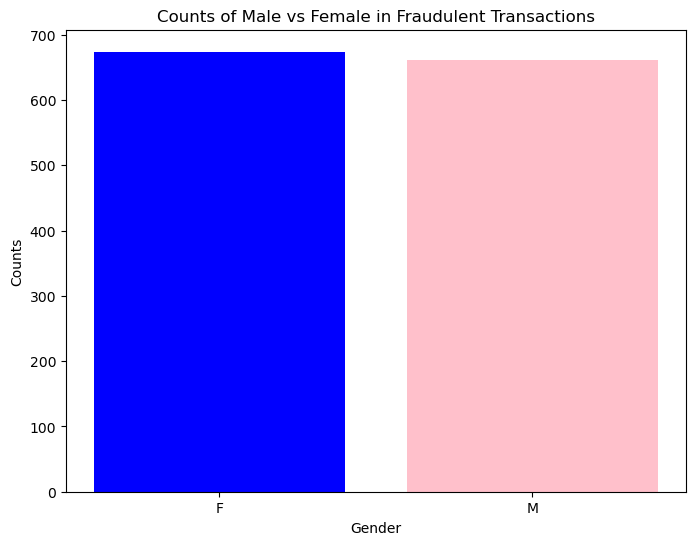

In [10]:
import matplotlib.pyplot as plt

fraud_df = df[df["isFraud"] == 1]
gender_counts = fraud_df["gender"].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(gender_counts.index, gender_counts.values, color=["blue", "pink"])
plt.xlabel("Gender")
plt.ylabel("Counts")
plt.title("Counts of Male vs Female in Fraudulent Transactions")
plt.show()

In [11]:
100 * df.isFraud.value_counts(normalize=True)

isFraud
0    99.265215
1     0.734785
Name: proportion, dtype: float64

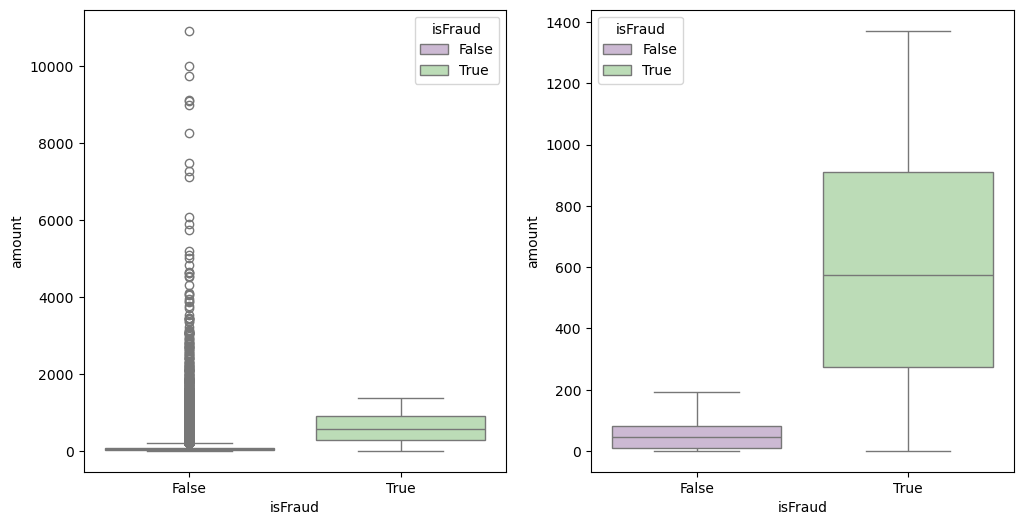

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
s = sns.boxplot(
    ax=ax1,
    x="isFraud",
    y="amount",
    hue="isFraud",
    data=df,
    palette="PRGn",
    showfliers=True,
)
s = sns.boxplot(
    ax=ax2,
    x="isFraud",
    y="amount",
    hue="isFraud",
    data=df,
    palette="PRGn",
    showfliers=False,
)
plt.show()

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181822 entries, 0 to 181821
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   business                    181822 non-null  category
 1   category                    181822 non-null  category
 2   amount                      181822 non-null  float64 
 3   firstName                   181822 non-null  object  
 4   lastName                    181822 non-null  object  
 5   gender                      181822 non-null  category
 6   street                      181822 non-null  object  
 7   state                       181822 non-null  category
 8   zip                         181822 non-null  object  
 9   cityPop                     181822 non-null  int64   
 10  isFraud                     181822 non-null  bool    
 11  distance_customer_merchant  181822 non-null  float64 
 12  city_fraudrate              181822 non-null  float64 
 13 

In [23]:
df.isnull().sum()

business                      0
category                      0
amount                        0
firstName                     0
lastName                      0
gender                        0
street                        0
state                         0
zip                           0
cityPop                       0
isFraud                       0
distance_customer_merchant    0
city_fraudrate                0
job_fraudrate                 0
historyOfFraud                0
trans_day                     0
trans_weekday                 0
trans_hour                    0
age_at_transaction            0
dtype: int64

In [26]:
df_train = df.drop(
    columns=[
        "business",
        "firstName",
        "lastName",
        "gender",
        "street",
        "zip",
    ]
)

In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181822 entries, 0 to 181821
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   category                    181822 non-null  category
 1   amount                      181822 non-null  float64 
 2   state                       181822 non-null  category
 3   cityPop                     181822 non-null  int64   
 4   isFraud                     181822 non-null  bool    
 5   distance_customer_merchant  181822 non-null  float64 
 6   city_fraudrate              181822 non-null  float64 
 7   job_fraudrate               181822 non-null  float64 
 8   historyOfFraud              181822 non-null  int64   
 9   trans_day                   181822 non-null  int32   
 10  trans_weekday               181822 non-null  int32   
 11  trans_hour                  181822 non-null  int32   
 12  age_at_transaction          181822 non-null  int32   
dtyp

In [28]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pandas as pd
import numpy as np

# Initialize the OneHotEncoder and LabelEncoder
onehot_encoder = OneHotEncoder(
    sparse=False
)  # Setting sparse=False ensures the output is a numpy array
label_encoder_state = LabelEncoder()

# Reshape the 'category' column to a 2D array as OneHotEncoder expects a 2D input
categories = df_train["category"].values.reshape(-1, 1)

# Fit and transform the 'category' column using OneHotEncoder
categories_encoded = onehot_encoder.fit_transform(categories)

# Convert the encoded categories back to a DataFrame
categories_encoded_df = pd.DataFrame(
    categories_encoded, columns=onehot_encoder.get_feature_names_out(["category"])
)

# Reset index on your original DataFrame if necessary to ensure indices align when concatenating
df_train.reset_index(drop=True, inplace=True)

# Concatenate the original DataFrame with the new one-hot encoded DataFrame
df_train_encoded = pd.concat([df_train, categories_encoded_df], axis=1)

# Drop the original 'category' column as it's now encoded
df_train_encoded.drop("category", axis=1, inplace=True)

# Fit and transform the 'state' column using LabelEncoder
df_train_encoded["state"] = label_encoder_state.fit_transform(df_train_encoded["state"])

# Check the first few rows to verify
print(df_train_encoded.head())

# Optional: Print the mapping for the 'state' column
state_mapping = dict(
    zip(
        label_encoder_state.classes_,
        label_encoder_state.transform(label_encoder_state.classes_),
    )
)
print("State Mapping:", state_mapping)

   amount  state  cityPop  isFraud  distance_customer_merchant  \
0    4.10     13     6713    False                   47.229861   
1    2.67     16      798    False                  736.663198   
2   22.88      4      337    False                16355.218443   
3    9.59     11     3032    False                19437.754509   
4  129.06     48     1925    False                 1213.023317   

   city_fraudrate  job_fraudrate  historyOfFraud  trans_day  trans_weekday  \
0        0.000000       0.000000               0          1              1   
1        0.000000       1.284404               0          1              1   
2        0.000000       0.000000               0          1              1   
3        0.000000       0.000000               0          1              1   
4        4.577465       1.186131               1          1              1   

   ...  category_grocery_pos  category_health_fitness  category_home  \
0  ...                   0.0                      0.0         

/Users/michael/.pyenv/versions/miniforge3-4.10.3-10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [29]:
df_train_encoded.head()

,amount,state,cityPop,isFraud,distance_customer_merchant,city_fraudrate,job_fraudrate,historyOfFraud,trans_day,trans_weekday,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,4.10,13,6713,False,47.229861,0.000000,0.000000,0,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2.67,16,798,False,736.663198,0.000000,1.284404,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,22.88,4,337,False,16355.218443,0.000000,0.000000,0,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,9.59,11,3032,False,19437.754509,0.000000,0.000000,0,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,129.06,48,1925,False,1213.023317,4.577465,1.186131,1,1,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
df_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181822 entries, 0 to 181821
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   amount                      181822 non-null  float64
 1   state                       181822 non-null  int64  
 2   cityPop                     181822 non-null  int64  
 3   isFraud                     181822 non-null  bool   
 4   distance_customer_merchant  181822 non-null  float64
 5   city_fraudrate              181822 non-null  float64
 6   job_fraudrate               181822 non-null  float64
 7   historyOfFraud              181822 non-null  int64  
 8   trans_day                   181822 non-null  int32  
 9   trans_weekday               181822 non-null  int32  
 10  trans_hour                  181822 non-null  int32  
 11  age_at_transaction          181822 non-null  int32  
 12  category_entertainment      181822 non-null  float64
 13  category_food_

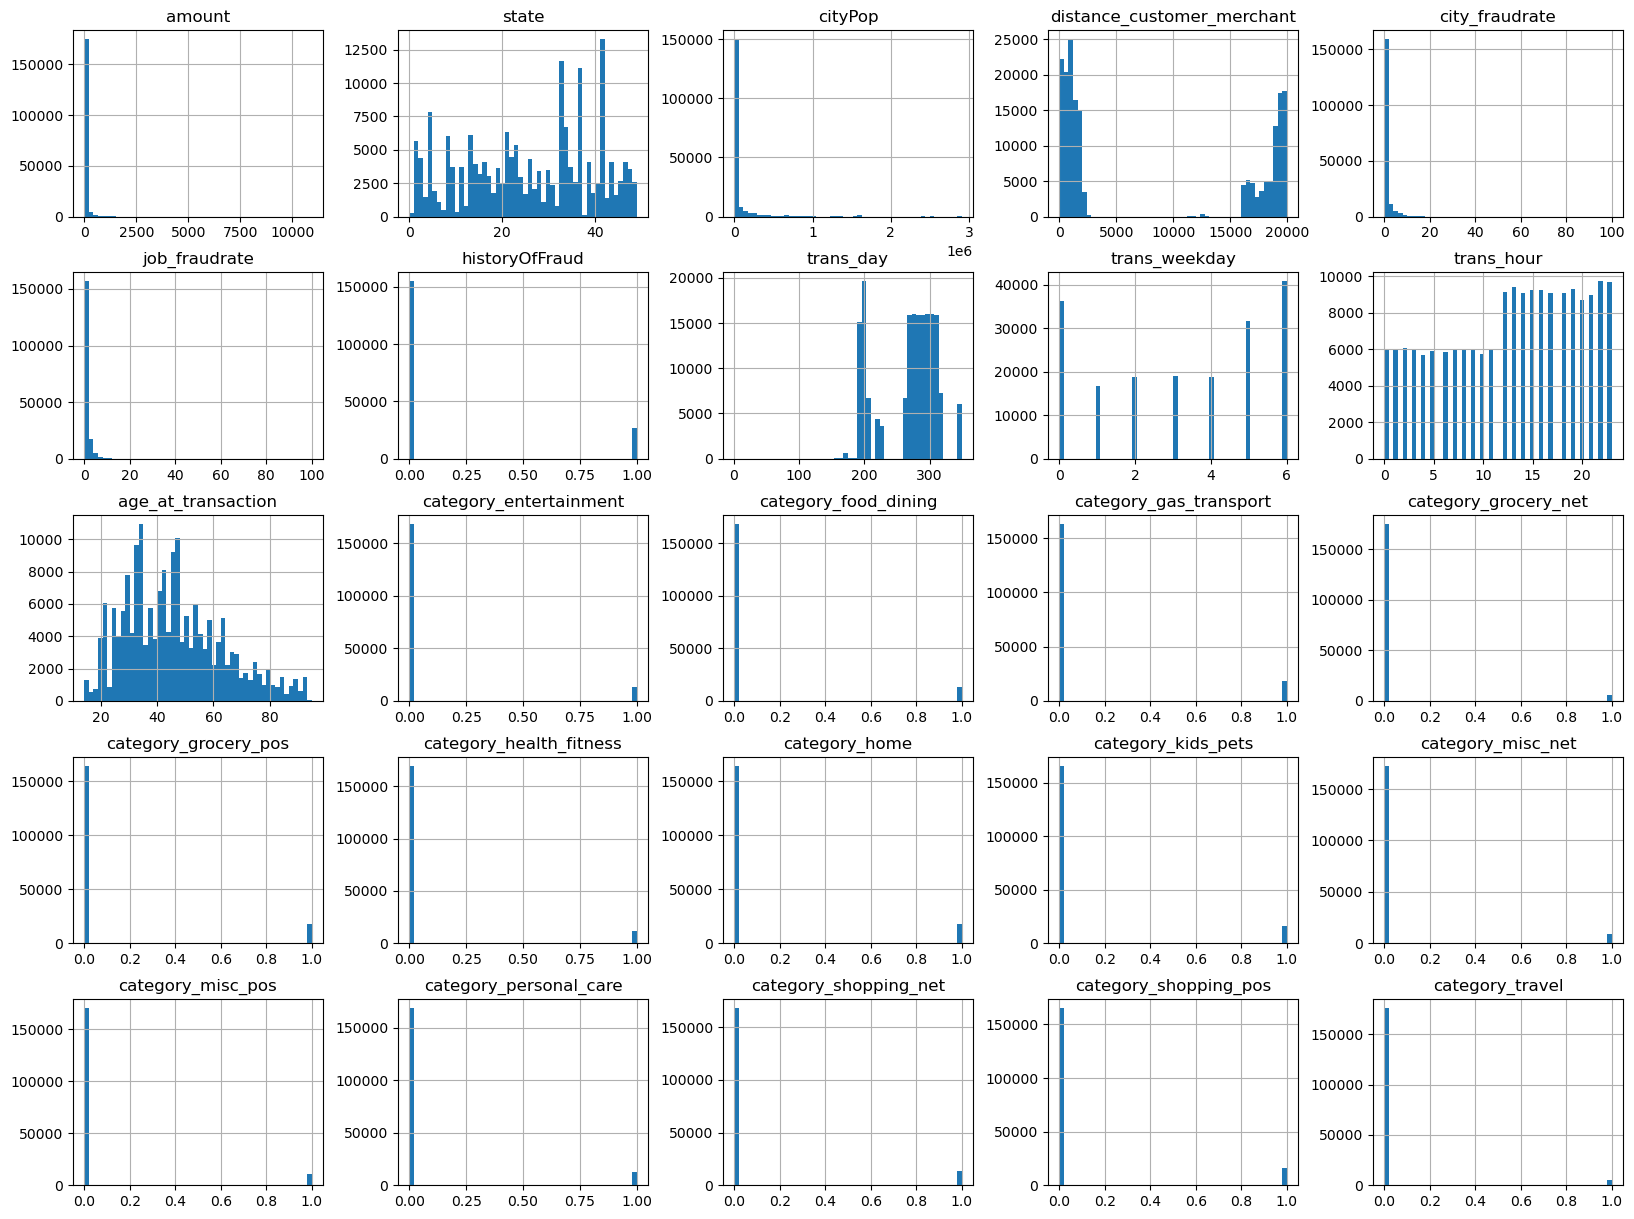

In [31]:
df_train_encoded.hist(bins=50, figsize=(20, 15))

<Axes: >

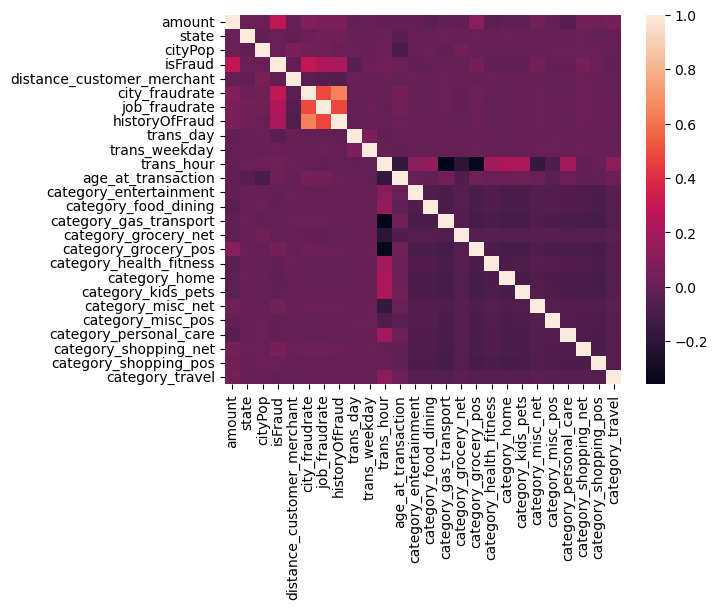

In [36]:
corr_matrix = df_train_encoded.corr()
sns.heatmap(corr_matrix, yticklabels=True)

In [37]:
corr_matrix["isFraud"].sort_values(ascending=False)

isFraud                       1.000000
city_fraudrate                0.284640
amount                        0.282902
job_fraudrate                 0.226799
historyOfFraud                0.206077
category_shopping_net         0.052611
category_grocery_pos          0.039221
category_misc_net             0.028487
trans_hour                    0.022698
age_at_transaction            0.013262
category_shopping_pos         0.011507
trans_weekday                 0.010622
cityPop                       0.009632
state                         0.006775
category_gas_transport       -0.006114
category_grocery_net         -0.008503
category_travel              -0.009104
category_misc_pos            -0.009484
distance_customer_merchant   -0.011468
category_entertainment       -0.013400
category_personal_care       -0.014043
category_health_fitness      -0.016817
category_food_dining         -0.018768
category_kids_pets           -0.019225
category_home                -0.020704
trans_day                

In [38]:
pipelines = {
    "LogisticRegression": make_pipeline(StandardScaler(), LogisticRegression()),
    "KNeighborsClassifier": make_pipeline(StandardScaler(), KNeighborsClassifier()),
    "RandomForestClassifier": make_pipeline(StandardScaler(), RandomForestClassifier()),
    "DecisionTreeClassifier": make_pipeline(StandardScaler(), DecisionTreeClassifier()),
    "GradientBoostingClassifier": make_pipeline(
        StandardScaler(), GradientBoostingClassifier()
    ),
}

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train_encoded.drop(columns=["isFraud"]),
    df_train_encoded["isFraud"],
    test_size=0.2,
)

X_train.shape, y_train.shape, X_train.values, y_train.values

((145457, 25),
 (145457,),
 array([[3.6010e+01, 4.3000e+01, 3.0200e+02, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.1694e+02, 2.0000e+00, 7.1550e+03, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.7500e+00, 4.2000e+01, 1.0600e+02, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [4.3850e+01, 2.4000e+01, 1.1960e+03, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [9.3800e+00, 3.4000e+01, 3.1394e+04, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.3570e+01, 4.1000e+01, 2.5459e+04, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]]),
 array([False, False, False, ..., False, False, False]))

In [40]:
fit_models = {}
for algo, pipeline in pipelines.items():
    print(algo)
    model = pipeline.fit(X_train.values, y_train)
    fit_models[algo] = model

LogisticRegression
KNeighborsClassifier
RandomForestClassifier
DecisionTreeClassifier
GradientBoostingClassifier


In [41]:
from sklearn.model_selection import cross_val_score

for name, model in fit_models.items():
    print(f"Model: {name}")
    for metric in ["precision", "recall", "f1"]:
        scores = cross_val_score(model, X_test, y_test, cv=10, scoring=metric)
        mean_score = round(scores.mean() * 100, 2)
        print(f"--> {metric.capitalize()}: {mean_score}%")
    print("-" * 40)

Model: LogisticRegression
--> Precision: 85.82%
--> Recall: 44.54%
--> F1: 58.12%
----------------------------------------
Model: KNeighborsClassifier
--> Precision: 92.55%
--> Recall: 48.96%
--> F1: 63.51%
----------------------------------------
Model: RandomForestClassifier
--> Precision: 96.09%
--> Recall: 78.44%
--> F1: 85.71%
----------------------------------------
Model: DecisionTreeClassifier
--> Precision: 82.01%
--> Recall: 83.21%
--> F1: 82.26%
----------------------------------------
Model: GradientBoostingClassifier
--> Precision: 91.76%
--> Recall: 77.0%
--> F1: 83.77%
----------------------------------------


In [42]:
rtc = RandomForestClassifier(
    max_features=0.4,
    max_depth=None,
    min_samples_leaf=2,
    criterion="gini",
    random_state=42,
    n_estimators=1000,
    n_jobs=-1,
)

rtc.fit(X_train, y_train)

y_pred = rtc.predict_proba(X_test)[:, 1] >= 0.479
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9987350474357212
Precision: 0.9634146341463414
Recall: 0.864963503649635
F1 Score: 0.9115384615384615
Confusion Matrix:
 [[36082     9]
 [   37   237]]


In [43]:
importance = rtc.feature_importances_

# Sort feature importance in descending order
sorted_importance = sorted(zip(importance, X_train.columns), reverse=True)

# Print feature importance in descending order
for i, f in enumerate(sorted_importance):
    print("{:2d}) {:<30} {:.2%}".format(i + 1, f[1], f[0]))

 1) amount                         39.61%
 2) trans_day                      12.35%
 3) city_fraudrate                 9.42%
 4) historyOfFraud                 8.76%
 5) category_grocery_pos           7.04%
 6) trans_hour                     6.66%
 7) job_fraudrate                  4.14%
 8) category_gas_transport         2.32%
 9) trans_weekday                  1.82%
10) age_at_transaction             1.56%
11) distance_customer_merchant     1.33%
12) cityPop                        0.93%
13) state                          0.71%
14) category_misc_pos              0.66%
15) category_travel                0.61%
16) category_shopping_net          0.43%
17) category_entertainment         0.30%
18) category_home                  0.30%
19) category_misc_net              0.26%
20) category_grocery_net           0.21%
21) category_shopping_pos          0.15%
22) category_health_fitness        0.12%
23) category_personal_care         0.11%
24) category_kids_pets             0.11%
25) category_f

In [44]:
df_train_encoded.to_pickle("model_data.pkl")

### CHECK UNDERSMAPLING AND SMOTE, run again


In [30]:
fraud = df[df.isFraud == 1]
normal = df[df.isFraud == 0]

print(f"Num Total txns: {df.shape[0]}")
print(f"Num fraud txns: {fraud.shape[0]}")
print(f"Num normal txns: {normal.shape[0]}")
print(f"% of fraud of all: {fraud.shape[0] / df.shape[0] * 100:.4f}%")

Num Total txns: 181822
Num fraud txns: 1336
Num normal txns: 180486
% of fraud of all: 0.7348%


In [58]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=0.5)
X = df_train_encoded.drop(columns=["isFraud"])
Y = df_train_encoded["isFraud"]
X_rus, y_rus = rus.fit_resample(X, Y)
y_rus.value_counts()

isFraud
False    2672
True     1336
Name: count, dtype: int64

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X_rus, y_rus, test_size=0.2, random_state=42, stratify=y_rus
)

rtc = RandomForestClassifier(
    max_features=0.4,
    max_depth=None,
    min_samples_leaf=2,
    criterion="gini",
    random_state=42,
    n_estimators=1000,
    n_jobs=-1,
)

rtc.fit(X_train, y_train)

y_pred = rtc.predict_proba(X_test)[:, 1] >= 0.479
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9887780548628429
Precision: 0.9849624060150376
Recall: 0.9812734082397003
F1 Score: 0.9831144465290806
Confusion Matrix:
 [[531   4]
 [  5 262]]


In [60]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, Y)

y_ros.value_counts()

isFraud
False    180486
True     180486
Name: count, dtype: int64

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X_ros, y_ros, test_size=0.8, random_state=42, stratify=y_ros
)

rtc = RandomForestClassifier(
    max_features=0.4,
    max_depth=None,
    min_samples_leaf=2,
    criterion="gini",
    random_state=42,
    n_estimators=1000,
    n_jobs=-1,
)

rtc.fit(X_train, y_train)

y_pred = rtc.predict_proba(X_test)[:, 1] >= 0.479
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9989957683757072
Precision: 0.9979955625902861
Recall: 1.0
F1 Score: 0.9989967758451299
Confusion Matrix:
 [[144099    290]
 [     0 144389]]


In [61]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy="minority")

X_sm, y_sm = smote.fit_resample(X, Y)

y_sm.value_counts()

isFraud
False    180486
True     180486
Name: count, dtype: int64

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.3, random_state=42, stratify=y_sm
)

rtc = RandomForestClassifier(
    max_features=0.4,
    max_depth=None,
    min_samples_leaf=2,
    criterion="gini",
    random_state=42,
    n_estimators=1000,
    n_jobs=-1,
)

rtc.fit(X_train, y_train)

y_pred = rtc.predict_proba(X_test)[:, 1] >= 0.479
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9994367081594209
Precision: 0.9994459322190414
Recall: 0.9994274738669523
F1 Score: 0.9994367029577711
Confusion Matrix:
 [[54116    30]
 [   31 54115]]


In [64]:
importance = rtc.feature_importances_

# Sort feature importance in descending order
sorted_importance = sorted(zip(importance, X_train.columns), reverse=True)

# Print feature importance in descending order
for i, f in enumerate(sorted_importance):
    print("{:2d}) {:<30} {:.2%}".format(i + 1, f[1], f[0]))

 1) historyOfFraud                 35.82%
 2) city_fraudrate                 25.00%
 3) amount                         16.12%
 4) job_fraudrate                  6.87%
 5) trans_day                      3.00%
 6) category_gas_transport         2.97%
 7) category_grocery_pos           1.60%
 8) trans_hour                     1.28%
 9) category_misc_pos              0.95%
10) category_food_dining           0.87%
11) category_personal_care         0.85%
12) category_kids_pets             0.65%
13) category_home                  0.58%
14) category_grocery_net           0.58%
15) category_shopping_net          0.48%
16) cityPop                        0.33%
17) category_travel                0.32%
18) category_health_fitness        0.29%
19) age_at_transaction             0.29%
20) distance_customer_merchant     0.26%
21) category_entertainment         0.25%
22) state                          0.22%
23) category_shopping_pos          0.19%
24) trans_weekday                  0.12%
25) category_